# Rastrigin - Otimização com Evolução Diferencial

A função de Rastrigin apresenta um desafio interessante para algoritmos de otimização, pois possui muitos mínimos locais e um mínimo global em (0, 0), sendo uma função multimodal e não convexa. A função de Rastrigin é definida por:

\begin{equation}
f(x) = An + \sum_{i=1}^{n} \left[ x_i^2 - A \cos(2\pi x_i) \right]
\end{equation}

Neste trabalho será implementado um algoritmo de evolução diferencial para otimizar a função de Rastrigin.

In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pandas import Series
from benchmark_functions import Rastrigin

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Função Objetivo

A função objetivo aqui utilizada possui um domíni estabelecido para o problema de otimização, onde $x_i \in [-5.12, 5.12]$ para todo $i$.

Para representações reais do problema, tal qual o algoritmo de evolução diferencial, é necessário utilizar uma função de penalição para valores fora do domínio. A função de penalição utilizada é a de restrição quadrática, que penaliza valores fora do domínio com um valor proporcional ao quadrado da diferença.

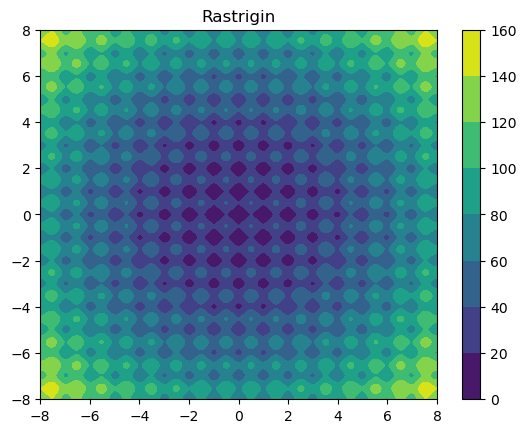

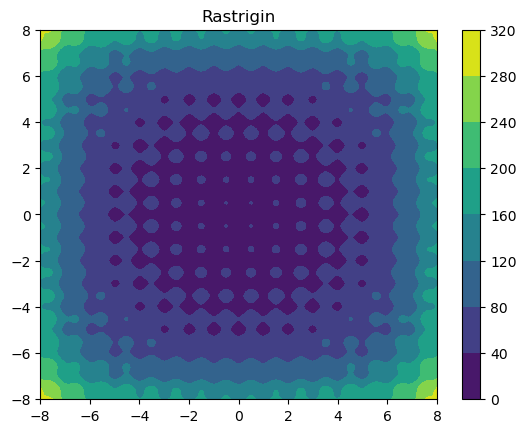

In [2]:
rastringin = Rastrigin(2)

points = np.linspace(-8, 8, 1000)

values = [rastringin([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

def rastringin_constrained_generator(rastringin):
    # Método utilizado: Penalização com parâmetro de penalização = 1000
    # Função de penalização 1: p * max(0, (x - 5.12))²
    # Função de penalização 2: p * max(0, (-x - 5.12))²
    # Obs: Por não ser realmente um problema de otimização convexa, iremos deixar o p fixado em 10, o que
    # não é um problema por sabermos que os mínimos locais são maiores que o global.
    p = 10
    def wrapper(x):
        return rastringin(x) + p * sum([max(0, (x_i - 5.12))**2 for x_i in x]) + p * sum([max(0, (-x_i - 5.12))**2 for x_i in x])
    
    return wrapper

rastringin_constrained = rastringin_constrained_generator(rastringin)

values = [rastringin_constrained([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

## Função em N=10

A função utilizada no problema real possui 10 dimensões, ou seja, $n=10$.

In [3]:
rastringin = Rastrigin(10)

rastringin_constrained = rastringin_constrained_generator(rastringin)

## Criação da População

Para iniciar a **população**, será utilizada uma amostragem aleatória uniforme no domínio da função. O tamanho da população será de 100 indivíduos.

In [4]:
def init_population(_mu:int = 100, n:int = 10):
    population = []
    for i in range (_mu):
        population.append([rd.uniform(-5.12, 5.12) for _ in range(n)])
    return population

## Mutação Diferencial

A mutação diferencial é uma operação que cria um vetor mutante a partir de três vetores da população. A fórmula do algoritmo canônico para a mutação é:

\begin{equation}
v_{i,G} = x_{r1,G} + F \cdot (x_{r2,G} - x_{r3,G})
\end{equation}

Onde $v_{i,G}$ é o vetor mutante, $x_{r1,G}$, $x_{r2,G}$ e $x_{r3,G}$ são vetores da população, $F$ é um fator de escala e $i$ é o índice do vetor mutante.

Neste trabalho, iremos testar também a mutação diferencial com estratégia de uso da melhor solução da população e da solução média da população. Isto possibilitará um estudo comparativo entre as estratégias.

As equações respectivas para as mutações são:

\begin{equation}
v_{i,G} = x_{best,G} + F \cdot (x_{r2,G} - x_{r3,G})
\end{equation}

\begin{equation}
v_{i,G} = x_{mean,G} + F \cdot (x_{r2,G} - x_{r3,G})
\end{equation}

### Cruzamento Binomial

O cruzamento binomial é uma operação que combina o vetor mutante com o vetor alvo. A fórmula para o cruzamento é:

\begin{equation}
u_{i,j,G} = \begin{cases} v_{i,j,G} & \text{se } rand(0, 1) \leq CR \text{ ou } j = rand(1, n) \\ x_{i,j,G} & \text{caso contrário} \end{cases}
\end{equation}

Onde $u_{i,j,G}$ é o vetor filho, $v_{i,j,G}$ é o vetor mutante, $x_{i,j,G}$ é o vetor alvo, $CR$ é a taxa de cruzamento e $j$ é o índice do vetor filho.

In [5]:
def mutate_pop(pop, F, strategy="canonical"):
    # NOTE: Nada impede de o operador de mutação combinado com o de recombinção gerar um indivíduo inválido,
    # porém, como a função de penalização é bem definida, o indivíduo inválido será penalizado.
    children = []
    for i in range(len(pop)):

        # não posso ter a == b; a == c; a, b ou c == i
        pop_without_i = pop.copy()
        pop_without_i.pop(i)
        a, b, c = rd.sample(pop_without_i, 3)
        if strategy == "canonical":
            child = [a[i] + F * (b[i] - c[i]) for i in range(len(a))]
        elif strategy == "best":
            best = min(pop, key=rastringin_constrained)
            child = [best[i] + F * (b[i] - c[i]) for i in range(len(a))]
        elif strategy == "average":
            average = np.mean(pop, axis=0)
            child = [average[i] + F * (b[i] - c[i]) for i in range(len(a))]
        else:
            raise ValueError("Invalid strategy")
        
        children.append(child)

    return children

def crossover(pop, children, crossover_rate):
    k = rd.randint(0, len(pop[0]))
    children = [[children[i][j] if rd.random() < crossover_rate or j == k else pop[i][j] for j in range(len(pop[0]))] for i in range(len(pop))]
    return children

## Seleção

A seleção é uma operação que escolhe o vetor alvo ou o vetor filho para a próxima geração. A fórmula para a seleção é:

\begin{equation}
x_{i,G+1} = \begin{cases} v_{i,G} & \text{se } f(v_{i,G}) \leq f(x_{i,G}) \\ x_{i,G} & \text{caso contrário} \end{cases}
\end{equation}

In [6]:
def selection(pop, children):
    return [min(pop[i], children[i], key=rastringin_constrained) for i in range(len(pop))]

## Função de Teste

In [7]:
def find_best_solution(mutation_strategy, max_gens=100):
    pop = init_population()

    current_generation = 0
    fitness_pop_vectors = []

    while True:
        fitness_pop = [rastringin_constrained(sol) for sol in pop]
        fitness_pop_vectors.append(min(fitness_pop))

        if 0 in fitness_pop or current_generation >= max_gens:
            break

        mutated_pop = mutate_pop(pop, 0.5, mutation_strategy)

        crossover_pop = crossover(pop, mutated_pop, 0.5)

        pop = selection(pop, crossover_pop)

        current_generation += 1

    best_solution = pop[np.argmin(fitness_pop)]
    
    best_solution_fitness = min(fitness_pop)
    
    return best_solution, best_solution_fitness, current_generation, fitness_pop_vectors

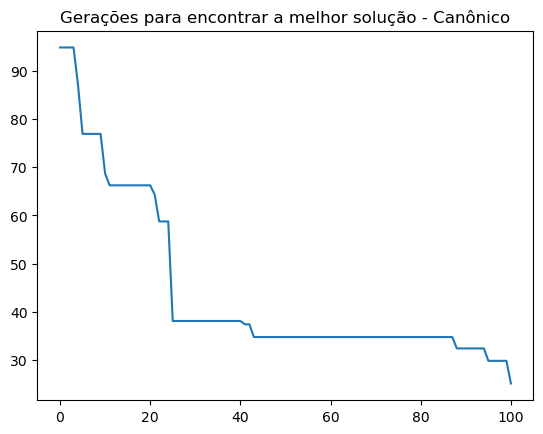

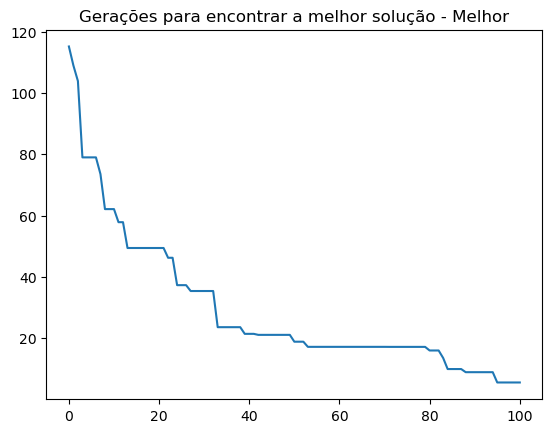

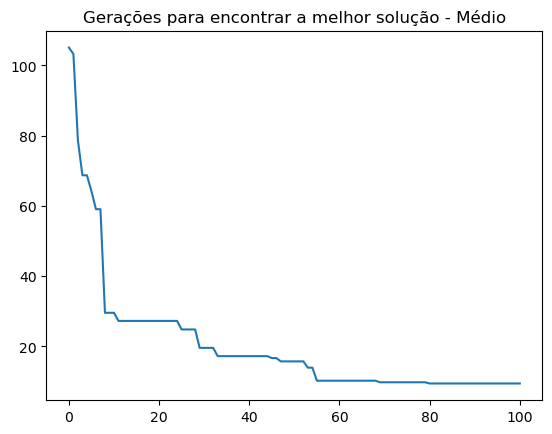

In [8]:
best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(mutation_strategy="canonical", max_gens=100)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - Canônico")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(mutation_strategy="best", max_gens=100)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - Melhor")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(mutation_strategy="average", max_gens=100)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - Médio")
plt.show()

## Conclusões

Todas as estratégias de mutação e cruzamento foram testadas e comparadas, sendo que o resultado de ambas foi positivo. A estratégia de mutação com a solução média obteve o melhor resultado e teve uma otimização mais suave, enquanto a estratégia de mutação com a melhor solução possuiu um maior tempo de processamento por ter de avaliar a função de Rastringin para cada indivíduo da população.

Este resultado provavelmente ocorreu pelo fato de que a solução ótima da função ocorre na origem, e a solução média da população tende a se aproximar da origem mais rapidamente do que a melhor solução ou uma solução aleatória.

# Rastringin - Otimização com PSO

A função de Rastrigin apresenta um desafio interessante para algoritmos de otimização, pois possui muitos mínimos locais e um mínimo global em (0, 0), sendo uma função multimodal e não convexa. A função de Rastrigin é definida por:

\begin{equation}
f(x) = An + \sum_{i=1}^{n} \left[ x_i^2 - A \cos(2\pi x_i) \right]
\end{equation}

Neste trabalho será implementado um algoritmo de enxame de partículas para otimizar a função de Rastrigin, utilizando o Global Best PSO com o algoritmo canônico e uma variação utilizando o operador de contrição $\chi$.

In [9]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pandas import Series
from benchmark_functions import Rastrigin

## Função Objetivo

A função objetivo aqui utilizada possui um domíni estabelecido para o problema de otimização, onde $x_i \in [-5.12, 5.12]$ para todo $i$.

Para representações reais do problema, tal qual o algoritmo de evolução diferencial, é necessário utilizar uma função de penalição para valores fora do domínio. A função de penalição utilizada é a de restrição quadrática, que penaliza valores fora do domínio com um valor proporcional ao quadrado da diferença.

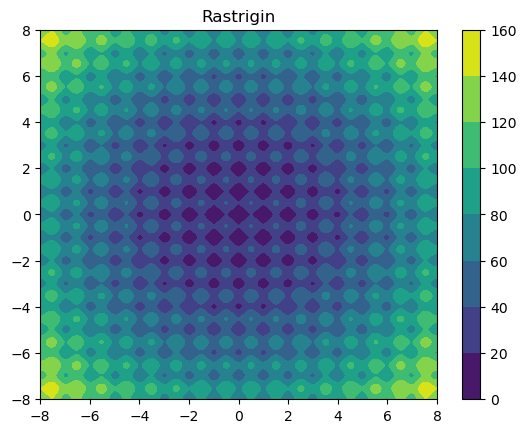

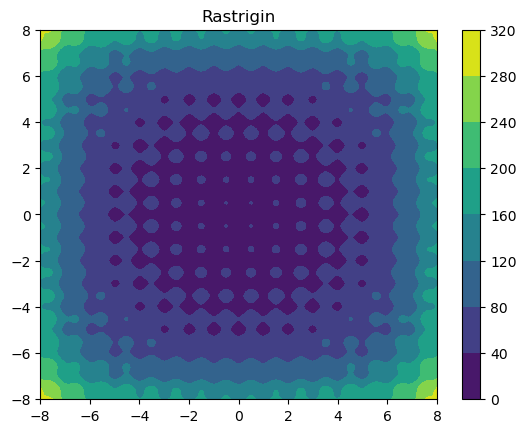

In [10]:
rastringin = Rastrigin(2)

points = np.linspace(-8, 8, 1000)

values = [rastringin([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

def rastringin_constrained_generator(rastringin):
    # Método utilizado: Penalização com parâmetro de penalização = 1000
    # Função de penalização 1: p * max(0, (x - 5.12))²
    # Função de penalização 2: p * max(0, (-x - 5.12))²
    # Obs: Por não ser realmente um problema de otimização convexa, iremos deixar o p fixado em 10, o que
    # não é um problema por sabermos que os mínimos locais são maiores que o global.
    p = 10
    def wrapper(x):
        return rastringin(x) + p * sum([max(0, (x_i - 5.12))**2 for x_i in x]) + p * sum([max(0, (-x_i - 5.12))**2 for x_i in x])
    
    return wrapper

rastringin_constrained = rastringin_constrained_generator(rastringin)

values = [rastringin_constrained([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

## Função em N=10

A função utilizada no problema real possui 10 dimensões, ou seja, $n=10$.

In [11]:
rastringin = Rastrigin(10)

rastringin_constrained = rastringin_constrained_generator(rastringin)

## Criação da População

Para iniciar a **população**, será utilizada uma amostragem aleatória uniforme no domínio da função. O tamanho da população será de 100 indivíduos.

E, relação à velocidade de cada partícula, todos indivíduos iniciarão com valores nulos em cada um dos eixos.

Para conseguir armazenar todas estas informações, além da melhor posição individual e global, será criada uma classe chamada `Particle`, cujo método update será responsável por atualizar a posição e a velocidade de cada partícula.

> Neste código podemos notar que a melhor posição é a global_best_position, isto se deve ao fato de estarmos implementando o Global Best PSO, onde a melhor posição global é a que é utilizada para atualizar a velocidade de cada partícula. Possíveis testes de melhoria do algoritmo poderiam ser feitos utilizando o Local Best PSO.

In [12]:
class Particle:
    def __init__(self, position, velocity, velocity_function):
        self.position = position
        self.velocity = velocity
        self.best_position = position
        self.best_value = rastringin_constrained(position)
        self.velocity_function = velocity_function # Função de atualização de velocidade, será implementada posteriormente
        self.updates = 0

    def update(self, w, c1, c2, global_best_position):
        self.velocity = self.velocity_function(self.position, self.velocity, w, c1, c2, self.best_position, global_best_position)
        self.position = self.position + self.velocity
        value = rastringin_constrained(self.position)
        if value < self.best_value:
            self.best_value = value
            self.best_position = self.position
        self.updates += 1

    @property
    def value(self):
        return rastringin_constrained(self.position)

def init_population(_mu:int = 1000, n:int = 10, velocity_update_func=None) -> list[Particle]:
    population = []
    for i in range (_mu):
        position = np.array([rd.uniform(-5.12, 5.12) for _ in range(n)])
        velocity = np.zeros(n)
        population.append(Particle(position, velocity, velocity_update_func))
    return population

## Velocidade

A velocidade de cada partícula é atualizada de acordo com a seguinte equação:

\begin{equation}
v_{i+1} = w \cdot v_i + c_1 \cdot r_1 \cdot (pbest_i - x_i) + c_2 \cdot r_2 \cdot (gbest - x_i)
\end{equation}

Onde:
- $v_{i+1}$ é a velocidade da partícula na próxima iteração
- $w$ é o fator de inércia
- $v_i$ é a velocidade da partícula na iteração atual
- $c_1$ e $c_2$ são constantes de aceleração
- $r_1$ e $r_2$ são valores aleatórios entre 0 e 1
- $pbest_i$ é a melhor posição da partícula até o momento
- $gbest$ é a melhor posição global

## Posição

A posição de cada partícula é atualizada de acordo com a seguinte equação:

\begin{equation}
x_{i+1} = x_i + v_{i+1}
\end{equation}

Onde:
- $x_{i+1}$ é a posição da partícula na próxima iteração
- $x_i$ é a posição da partícula na iteração atual

In [13]:
def velocity_update(x, v, w, c1, c2, best_position, global_best_position, *args, **kwargs):
    return w*v + c1*rd.random()*(best_position - x) + c2*rd.random()*(global_best_position - x)

## Velocidade - Alternativa

Uma alternativa para a atualização da velocidade é a utilização de um coeficiente de contrição, que é uma função da constante de aceleração. A equação de atualização da velocidade é dada por:

\begin{equation}
v_{i+1} = \chi \left[ v_i + c_1 \cdot r_1 \cdot (pbest_i - x_i) + c_2 \cdot r_2 \cdot (gbest - x_i) \right]
\end{equation}

Onde $\chi$ é o coeficiente de contrição, que é dado por:

\begin{equation}
\chi = \frac{2 \cdot k}{|2 - \phi - \sqrt{\phi \cdot (\phi - 4)}|}
\end{equation}

E $\phi = c_1 \cdot r_1 + c_2 \cdot r_2$ representa a razão de aceleração.

Esta alternativa permite uma convergência mais rápida do algoritmo, uma vez que a velocidade é limitada por um fator de contrição. Além disto, neste algoritmo, podemos alterar o valor de $k$ entre 1 e 0 para diminuirmos iterativamente a exploração global e iniciarmos a exploração local. Este é exatamente o comportamento que desejamos para o algoritmo de otimização aqui implementado.


In [14]:
def velocity_update_constriction(x, v, w, c1, c2, best_position, global_best_position, *args, **kwargs):
    phi = c1 + c2
    assert phi >= 4 # Para evitar raízes negativas
    chi = 2 / abs(2 - phi - np.sqrt(phi * (phi-4)))
    v = chi * (w*v + c1*rd.random()*(best_position - x) + c2*rd.random()*(global_best_position - x))
    return v

In [15]:
def find_best_solution(max_gens:int = 10, velocity_update_func = velocity_update, w=0.9, c1=3, c2=5):
    pop = init_population(velocity_update_func=velocity_update_func)

    fitness_pop_vectors = []

    for gen in range(max_gens):
        global_best = min(pop, key=lambda x: x.value).position
        global_best_value = rastringin_constrained(global_best)
        for particle in pop:
            particle.update(w, c1, c2, global_best)
            if particle.best_value < global_best_value:
                global_best = particle.best_position
                global_best_value = particle.best_value
        fitness_pop_vectors.append(global_best_value)

    return global_best, global_best_value, fitness_pop_vectors

## Grid Search

Durante teste iniciais, foi possível observar que várias combinações, mesmo que com pequenas mudanças nos parâmetros, ocasionavam em resultados muito diferentes. Por isso, foi decidido realizar um grid search para encontrar os melhores parâmetros para o algoritmo.

In [16]:
from sklearn.model_selection import ParameterGrid

parameters = {
    "w": [0.5, 0.6, 0.7, 0.8, 0.9],
    "c1": [0, 1, 3, 5, 7, 9],
    "c2": [0, 1, 3, 5, 7, 9],
    "velocity_update_func": [velocity_update, velocity_update_constriction]
}

grid = ParameterGrid(parameters)

filtered_grid = [params for params in grid if params['c1'] + params['c2'] >= 4]

best_value_grid_search = float('inf')
best_params = None

for params in filtered_grid:
    _, global_best_value, fitness_pop_vectors = find_best_solution(max_gens=100, velocity_update_func=params['velocity_update_func'], w=params['w'], c1=params['c1'], c2=params['c2'])

    if global_best_value < best_value_grid_search:
        best_value_grid_search = global_best_value
        best_params = params

## Melhores Parâmetros

Os melhores parâmetros encontrados para o algoritmo foram:
- $w = 0.9$
- $c_1 = 9$
- $c_2 = 9$
- Função de Velocidade: Com Coeficiente de Contrição

Os resultados podem ser observados na seção de resultados.

## Resultados

Foi notado a forte influência dos parâmetros na convergência do algoritmo. A utilização do coeficiente de contrição permitiu uma convergência mais rápida do algoritmo, além de permitir a exploração local do espaço de busca.

Muitas combinações de parâmetros apresentaram melhorias pouco significativas, sendo que outras nem sequer conseguiram melhorar a solução. Isto mostra a importância de parâmetros bem ajustados para o algoritmo de otimização por enxame de partículas.

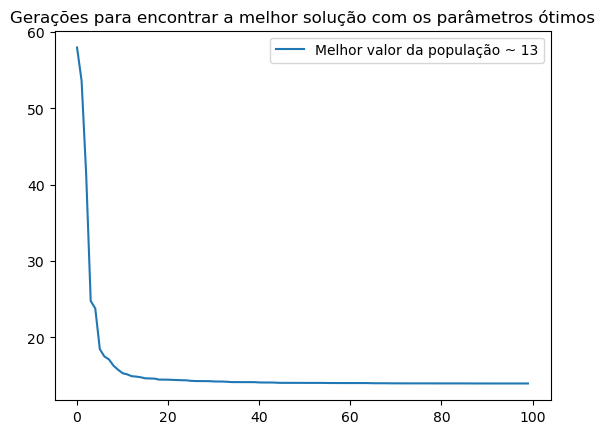

In [17]:
_, global_best_value, fitness_pop_vectors = find_best_solution(max_gens=100, velocity_update_func=best_params['velocity_update_func'], w=best_params['w'], c1=best_params['c1'], c2=best_params['c2'])

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução com os parâmetros ótimos")
plt.legend(["Melhor valor da população ~ " + str(global_best_value).split(".")[0]])
plt.show()

# TSP - Algoritmo Genético

O problema do caixeiro viajante (TSP) é um problema clássico de otimização combinatória. O problema pode ser formulado como: dado um conjunto de cidades e a distância entre cada par de cidades, encontrar o caminho mais curto que visita cada cidade exatamente uma vez e retorna à cidade de origem.

A formulação matemática utilizada neste trabalho, muito comum em contextos de pesquisa operacional, considera o custo Cij de percorrer uma cidade i a uma cidade j, assim como o caminho do grafo ser ou não percorrido (Xij).

Representando matemáticamente, temos:

$$\min \sum_{i=1}^{n} \sum_{j>i} c_{ij}x_{ij}$$


S.a.:
- $$\sum_{j<i} x_{ji} + \sum_{j>i} x_{ij} = 2, \quad \forall i \in \{1, 2, \dots, n\}$$
- $$\sum_{i,j \in S} x_{ij} \leq |S| - 1 \quad \forall S \subseteq N$$
- $$x \in \{0,1\}^{n(n-1)/2}$$

Neste trabalho, será utilizado um algoritmo genético por representação de permutação para resolver o problema do caixeiro viajante.

In [18]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pandas import Series

## Criação da População e Parâmetros

Para iniciar a **população**, utilizando uma representação em permutação, inicialmente é necessário criar uma lista de cidades, onde cada cidade é representada por um número inteiro. Esta lista de cidades é baseada no arquivo "att48.tsp", que contém as coordenadas das cidades.

Será criado um dicinário chamado "coordinates" que terá como chave o índice do indivíduo e como valor as coordenadas do indivíduo. O dicionário "coordinates" será utilizado para calcular a distância entre as cidades.

> A forma que o problema é representado já faz com que todas as restrições sejam atendidas, pois cada cidade é visitada uma única vez.

In [19]:
def init_population() -> tuple[list[int], dict[int, tuple[int, int]]]:
    solution = []
    coordinates = {}

    with open('att48.tsp', 'r') as file:
        for line in file:
            if not line[0].isdigit() and "EOF" not in line:
                continue
            elif "EOF" in line:
                break

            current_city, x, y = line.split()
            current_city = int(current_city)
            x = int(x)
            y = int(y)

            solution.append(current_city)
            coordinates[current_city] = (x, y)

    population = [solution.copy() for _ in range(75)]
    for i in range(len(population)):
        rd.shuffle(population[i])

    return population, coordinates

## Função de Aptidão

Definimos a **aptidão** como a distância total percorrida pelo caixeiro viajante. Para calcular a distância total, é necessário calcular a distância entre cada par de cidades e somar todas as distâncias. O objetivo é minimizar a distância total percorrida.

In [20]:
def fitness(solution: list[int], coordinates: dict[int, tuple[int, int]]) -> int:
    total_distance = 0

    for i in range(len(solution) - 1):
        current_city = solution[i]
        next_city = solution[i + 1]

        x1, y1 = coordinates[current_city]
        x2, y2 = coordinates[next_city]

        total_distance += ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    return total_distance

## Mutação da Solução (Swap)

Realizamos a **mutação** utilizando a técnica de **Swap**. Para isso, escolhemos aleatoriamente duas posições do vetor de representação do indivíduo e trocamos seus valores.
> **Exemplo:** Caso tenhamos escolhido as posições 2 e 4 para o vetor [0,1,2,3,4,5,6,7], teremos a mutação [0,1,4,3,2,5,6,7].

In [21]:
def mutate_solution_swap(solution):
    to_swap_lines = rd.sample(range(0,len(solution)), 2)
    solution[to_swap_lines[0]], solution[to_swap_lines[1]] = solution[to_swap_lines[1]], solution[to_swap_lines[0]]

## Seleção dos Pais

Para a **seleção dos pais**, utilizamos um método de **Torneio** alternativo. Neste método, escolhemos aleatoriamente cinco indivíduos da população e selecionamos os dois que possuem a menor função de aptidão como pais.

## Recombinação (Cut-and-crossﬁll)

Realizamos a **recombinação** utilizando a técnica de **Cut-and-crossﬁll**. Esse método irá criar dois filhos, cada um deles irá possuir uma parte inicial do vetor de um pai e irá 'retirar' os outros valores, que ainda não possui, do outro pai.

> Obs: As explicações de cada parte da técnica utilizada podem ser encontradas nos comentários dentro da própria função presente abaixo

In [22]:
def recombine_cut_and_crossfil(population, coordinates):
    # Escolha de 5 possíveis pais aleatoriamente
    random_possible_parents = [population[i] for i in rd.sample(range(0,len(population)), 5)]

    # Melhores duas possíveis soluções para pais
    best_possible_parents_indexes = np.argpartition([fitness(sol, coordinates) for sol in random_possible_parents] ,2)[:2]
    parent_1 = random_possible_parents[best_possible_parents_indexes[0]]
    parent_2 = random_possible_parents[best_possible_parents_indexes[1]]
    
    # Ter ao menos 1 elemento de cada pai para cada filho e preencher os filhos (inicialmente)
    first_section_cut_index = rd.choice(range(0, len(parent_1)-1))
    
    child_1 = np.zeros(len(parent_1))
    child_2 = np.zeros(len(parent_2))
    
    child_1[:first_section_cut_index+1] = parent_1[:first_section_cut_index+1]
    child_2[:first_section_cut_index+1] = parent_2[:first_section_cut_index+1]
    
    # Preenchendo o resto dos vetores filhos com as soluções dos próximos pais
    current_child_index = first_section_cut_index
    
    for value in parent_2:
        if current_child_index >= len(child_1)-1:
            break
        if value in child_1:
            continue
            
        child_1[current_child_index+1] = value
            
        current_child_index += 1
        
        
    current_child_index = first_section_cut_index
        
    for value in parent_1:
        if current_child_index >= len(child_2)-1:
            break
        if value in child_2:
            continue
            
        child_2[current_child_index+1] = value
            
        current_child_index += 1
        
    child_1 = [int(x) for x in child_1]
    child_2 = [int(x) for x in child_2]
        
    return child_1, child_2

## Escolha de Mutações

Realizamos com **10%** de chance a **mutação** para cada um dos dois filhos.

In [23]:
def mutate_childs(child_1, child_2):
    # Mutações em 10% das vezes para cada filho
    mutation_rate = 0.2
    
    if rd.uniform(0, 1) < mutation_rate:
        mutate_solution_swap(child_1)
        
    if rd.uniform(0, 1) < mutation_rate:
        mutate_solution_swap(child_2)

## Seleção de Candidatos

A **população** que continuará será referente aos n-2 indivíduos, após a inserção dos 2 filhos, que melhor se adaptam ao problema, ou seja, os 2  indivíduos com os piores valores de aptidão serão retirados da população.

In [24]:
def select_new_population(pop, child_1, child_2, coordinates):
    # Retirando piores duas soluções da nova população
    
    pop.append(child_1)
    pop.append(child_2)
    
    elements_indexes_to_pop = np.argpartition([fitness(sol, coordinates) for sol in pop], -2)[-2:]
    
    for index in sorted(elements_indexes_to_pop, reverse=True):
        del pop[index]
    
    return pop

## Encontrar a Solução
Uma função que nos permite realizar o processo de um **Algoritmo Evolucionário** de forma simples, sendo necessário escolher apenas a quantidade de indivíduos na população e quantas rainhas devem existir no tabuleiro. O formato do código se baseia no pseudocódigo descrito na Introdução.

In [25]:
def find_best_solution():
    max_generations = 100000

    pop, coordinates = init_population()

    current_generation = 0
    fitness_pop_vectors = []

    while True:
        fitness_pop = [fitness(sol, coordinates) for sol in pop]
        fitness_pop_vectors.append(min(fitness_pop))

        if 0 in fitness_pop or current_generation >= max_generations:
            break

        child_1, child_2 = recombine_cut_and_crossfil(pop, coordinates)

        mutate_childs(child_1, child_2)

        pop = select_new_population(pop, child_1, child_2, coordinates)

        current_generation += 1

    best_solution = pop[np.argmin(fitness_pop)]
    
    best_solution_fitness = min(fitness_pop)
    
    return best_solution, best_solution_fitness, current_generation, fitness_pop_vectors, coordinates

## Resultados

O algoritmo foi executado com 75 indivíduos e 10000 gerações. O resultado obtido foi uma distância de 40860, em que abaixo é possível noticiar o caminho percorrido pelo caixeiro viajante, assim como a evolução do algortimo.

Apesar de não ser o melhor resultado, o algoritmo genético foi capaz de encontrar uma boa solução para o caixeiro viajante e chegou em valores suficientemente bons com um tempo de execução razoável, tornando-se uma boa alternativa para a resolução do problema em casos de tempo restrito em comparação com métodos exatos.

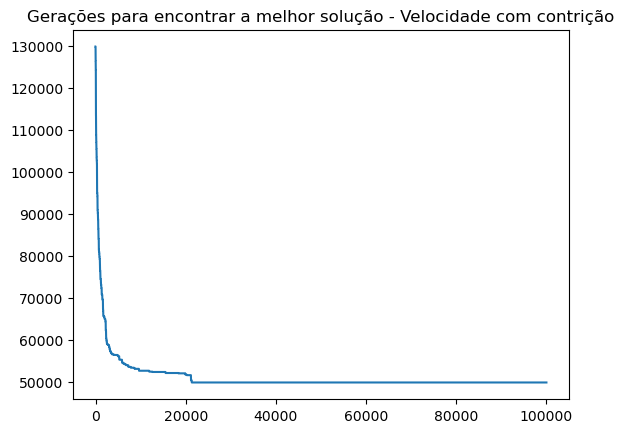

In [27]:
best_solution, best_solution_fitness, current_generation, fitness_pop_vectors, coordinates = find_best_solution()

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - Velocidade com contrição")
plt.show()


Text(0.5, 1.0, 'Melhor solução encontrada com fitness')

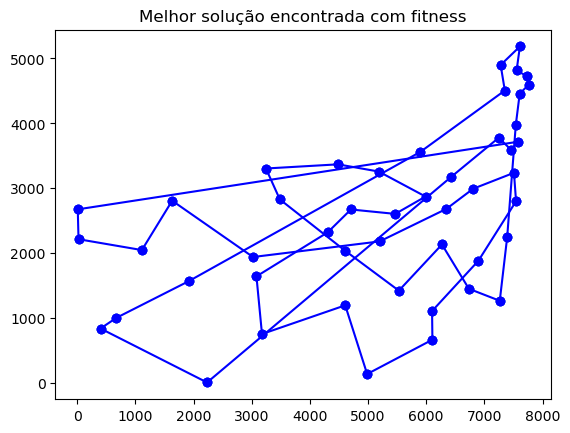

In [28]:
plt.figure()
x = [x for x, y in coordinates.values()]
y = [y for x, y in coordinates.values()]
plt.scatter(x, y)

for i in range(len(best_solution) - 1):
    plt.plot([coordinates[best_solution[i]][0], coordinates[best_solution[i + 1]][0]],
             [coordinates[best_solution[i]][1], coordinates[best_solution[i + 1]][1]], 'bo-')
plt.plot([coordinates[best_solution[-1]][0], coordinates[best_solution[0]][0]], [coordinates[best_solution[-1]][1], coordinates[best_solution[0]][1]], 'bo-')
plt.title(f"Melhor solução encontrada com fitness")